In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate
from tensorflow.keras.optimizers import SGD

### Load Data

In [4]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2020-10-26 03:51:52--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  99.4MB/s    in 1.9s    

2020-10-26 03:51:55 (99.4 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [5]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [6]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


### Data Preparation

In [7]:
# altough userId and movieId already seems in integer, it doesn't usually in form of index we need
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [8]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [9]:
df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,2,3.5,1112486027,0,1
1,1,29,3.5,1112484676,0,28
2,1,32,3.5,1112484819,0,31
3,1,47,3.5,1112484727,0,46
4,1,50,3.5,1112484580,0,49


In [10]:
user_ids = df.new_user_id.values
movie_ids = df.new_movie_id.values
ratings = df.rating.values

Train / Test Split

In [11]:
# shuffle first
rn = np.arange(user_ids.shape[0])
user_ids = user_ids[rn]
movie_ids = movie_ids[rn]
ratings = ratings[rn]

In [12]:
# Train data
frac = 0.8
Ntrain = int(frac * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_rating = ratings[:Ntrain]

In [13]:
# Test data
test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_rating = ratings[Ntrain:]

In [14]:
# Center ratings
rating_mean = train_rating.mean()
train_rating -= rating_mean
test_rating -= rating_mean

### Model Train

In [15]:
N = len(set(user_ids))
M = len(set(movie_ids))

K = 10

In [16]:
u = Input(shape=(1,)) # input user id
m = Input(shape=(1,)) # input movie id

u_emb = Embedding(N, K)(u)
m_emb = Embedding(M, K)(m)

u_f = Flatten()(u_emb)
m_f = Flatten()(m_emb)

x = Concatenate()([u_f, m_f])
x = Dense(1024, activation='relu')(x)
x = Dense(1)(x)

In [17]:
model = Model(inputs=[u, m], outputs=x)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        1384930     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        267440      input_2[0][0]                    
_______________________________________________________________________________________

In [18]:
model.compile(loss='mse', optimizer=SGD(lr=0.08, momentum=0.9))

In [19]:
r = model.fit(
    x=[train_user, train_movie],
    y=train_rating,
    epochs=25,
    batch_size=1024,
    # verbose=2,
    validation_data=([test_user, test_movie], test_rating)
)

Epoch 1/25
15626/15626 [==============================] - 59s 4ms/step - loss: 0.7694 - val_loss: 0.9123
Epoch 2/25
15626/15626 [==============================] - 59s 4ms/step - loss: 0.6957 - val_loss: 0.9172
Epoch 3/25
15626/15626 [==============================] - 58s 4ms/step - loss: 0.6721 - val_loss: 0.9069
Epoch 4/25
15626/15626 [==============================] - 59s 4ms/step - loss: 0.6587 - val_loss: 0.9084
Epoch 5/25
15626/15626 [==============================] - 59s 4ms/step - loss: 0.6461 - val_loss: 0.9134
Epoch 6/25
15626/15626 [==============================] - 59s 4ms/step - loss: 0.6289 - val_loss: 0.9136
Epoch 7/25
15626/15626 [==============================] - 58s 4ms/step - loss: 0.6146 - val_loss: 0.9119
Epoch 8/25
15626/15626 [==============================] - 58s 4ms/step - loss: 0.6052 - val_loss: 0.9144
Epoch 9/25
15626/15626 [==============================] - 58s 4ms/step - loss: 0.5968 - val_loss: 0.9142
Epoch 10/25
15626/15626 [==============================

### Model Evaluation

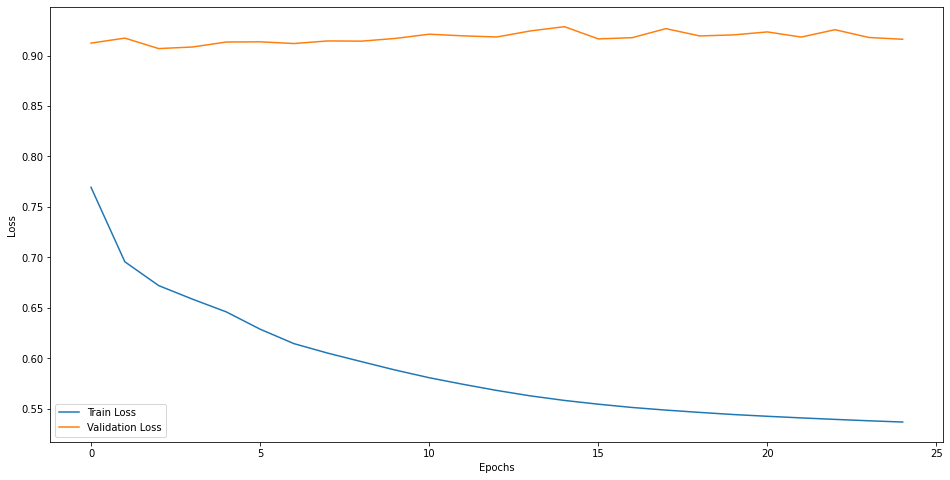

In [20]:
plt.figure(figsize=(16, 8))
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()